<a href="https://colab.research.google.com/github/Raghu290/sparkML/blob/master/credit_card_gan_wgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
#i have mounted my google drive for dataset reference and one python file reference.
#same is shared while project submission
#from google.colab import drive
#drive.mount('/content/drive')

In [34]:
import psutil ; print(list(psutil.virtual_memory())[0:2])

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb

import pickle

import gc
gc.collect()
print(list(psutil.virtual_memory())[0:2])

[13653602304, 11845541888]
[13653602304, 11847397376]


In [35]:

import drive.MyDrive.multi_gan as multi_gan

# For reloading after making changes
import importlib
importlib.reload(multi_gan) 
from drive.MyDrive.multi_gan import *

In [36]:
data = pd.read_csv("/content/drive/MyDrive/creditcard.csv")
data.head(3)

label_cols = ['Class']
data_cols = list(data.columns[ data.columns != 'Class' ])


# Total nulls in dataset (sum over rows, then over columns)

data.isnull().sum().sum()


0

In [37]:
data.skew()

Time      -0.035568
V1        -3.280667
V2        -4.624866
V3        -2.240155
V4         0.676292
V5        -2.425901
V6         1.826581
V7         2.553907
V8        -8.521944
V9         0.554680
V10        1.187141
V11        0.356506
V12       -2.278401
V13        0.065233
V14       -1.995176
V15       -0.308423
V16       -1.100966
V17       -3.844914
V18       -0.259880
V19        0.109192
V20       -2.037155
V21        3.592991
V22       -0.213258
V23       -5.875140
V24       -0.552499
V25       -0.415793
V26        0.576693
V27       -1.170209
V28       11.192091
Amount    16.977724
Class     23.997579
dtype: float64

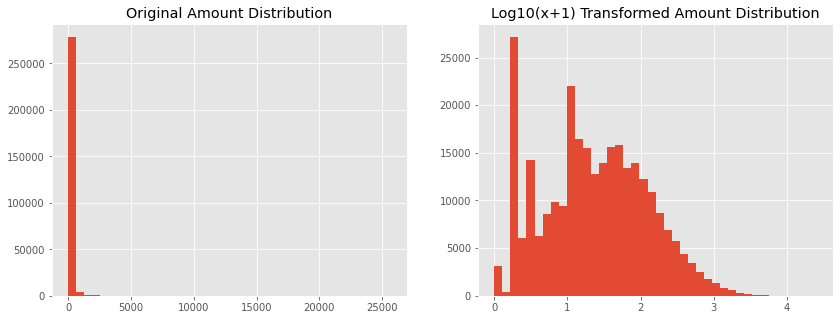

In [38]:
#doing log transaformation of amount

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(data['Amount'], bins=40)
plt.title('Original Amount Distribution')

plt.subplot(1,2,2)
d0 = np.log10( data['Amount'].values + 1 )
# d0 = np.log1p( data['Amount'].values ) / np.log(10)
plt.hist( d0, bins=40 )
plt.title('Log10(x+1) Transformed Amount Distribution')
plt.show()
data['Amount'] = d0

In [39]:
percentiles =  pd.DataFrame( np.array([ np.percentile( data[i], [ 0.1, 99.0 ] ) for i in data_cols ]).T,
                            columns=data_cols, index=['min','max'] )
percentile_means = \
    [ [ np.mean( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=data_cols, index=['mean']) )

percentile_stds = \
    [ [ np.std( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=data_cols, index=['stdev']) )

percentiles

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
min,204.000000,-16.044343,-15.126221,-9.870326,-4.163262,-9.408512,-5.290163,-9.365179,-13.102174,-3.305247,-5.209875,-2.739511,-5.702560,-3.103261,-7.342516,-3.185304,-4.028148,-5.702709,-3.351918,-2.981355,-6.621889,-5.490204,-3.119845,-5.452756,-2.001248,-2.403083,-1.276676,-3.823857,-2.629030,0.000000
max,170560.940000,2.237130,3.801811,2.728434,4.248032,3.424903,4.200085,2.696205,2.075973,2.986773,3.253618,2.290583,1.698576,2.513962,2.150300,1.925527,1.874820,2.289928,2.068689,2.262924,2.412190,1.931852,1.530152,1.508703,1.063748,1.203955,1.158698,0.931360,0.541126,3.008161
mean,94133.306637,-0.000389,-0.033636,-0.014882,-0.046762,-0.037545,-0.043613,-0.035107,-0.017567,-0.037496,-0.048290,-0.027239,-0.011008,-0.025590,-0.017588,-0.019332,-0.015121,-0.018637,-0.018785,-0.025031,-0.028353,-0.034019,-0.014768,-0.019273,-0.010145,-0.012343,-0.013825,-0.011702,-0.009058,1.359122
stdev,47021.185557,1.809969,1.346941,1.397548,1.313813,1.133824,1.185368,0.942000,0.907440,1.000831,0.839672,0.967521,0.920679,0.951643,0.851280,0.884234,0.813231,0.668728,0.791194,0.758483,0.498626,0.424583,0.687390,0.365549,0.589744,0.489247,0.456237,0.300049,0.204666,0.692078


In [40]:
data[data_cols] = ( data[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]


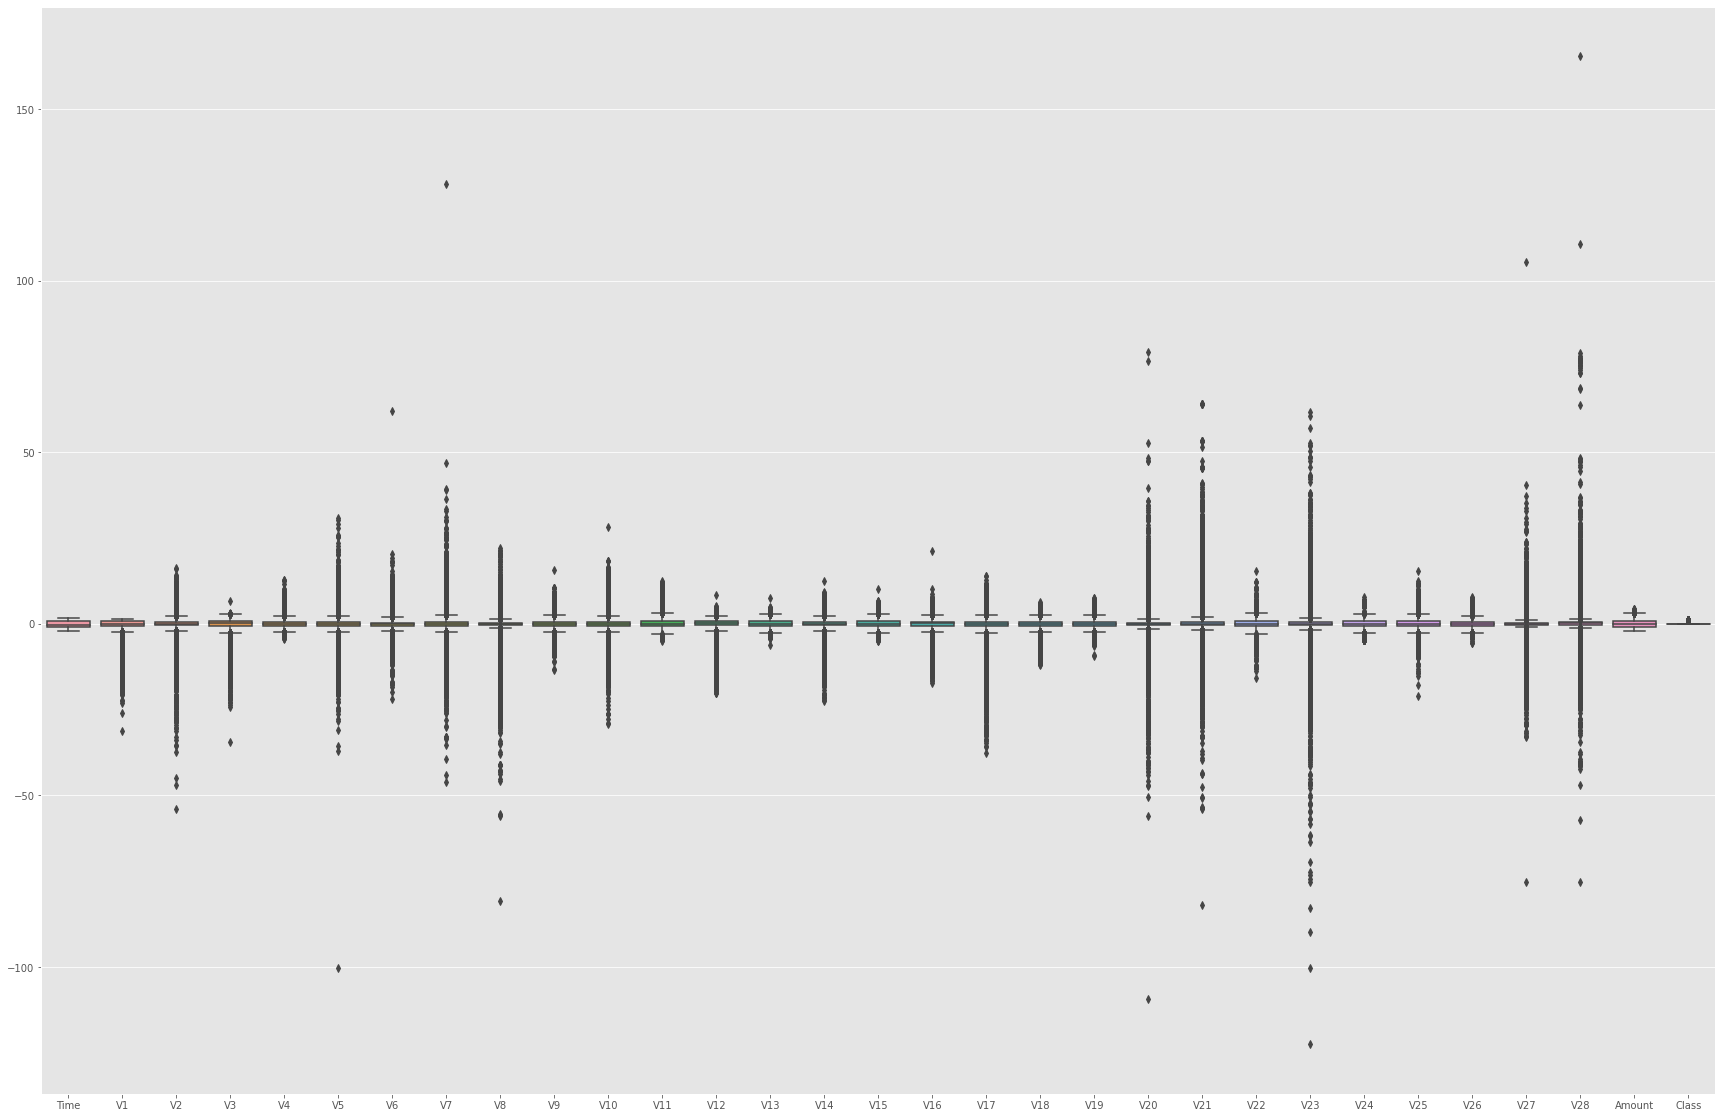

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
fig_dims = (30, 20)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(ax=ax, data = data) 

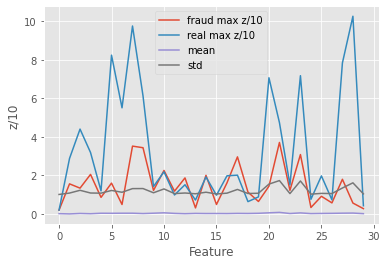

In [42]:

plot_cols = data_cols
# plt.plot( np.log10( data[ plot_cols ].abs().max().values ) )
# plt.plot( data[ plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='max z/10' )
plt.plot( data.loc[ data.Class==1, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='fraud max z/10' )
plt.plot( data.loc[ data.Class==0, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='real max z/10' )
plt.plot( data[ plot_cols ].mean().values, label='mean' )
# plt.plot( data[ plot_cols ].abs().mean().values, label='abs mean' )
plt.plot( data[ plot_cols ].std().values, label='std' )
plt.xlabel('Feature')
plt.ylabel('z/10')
plt.legend() ; 

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

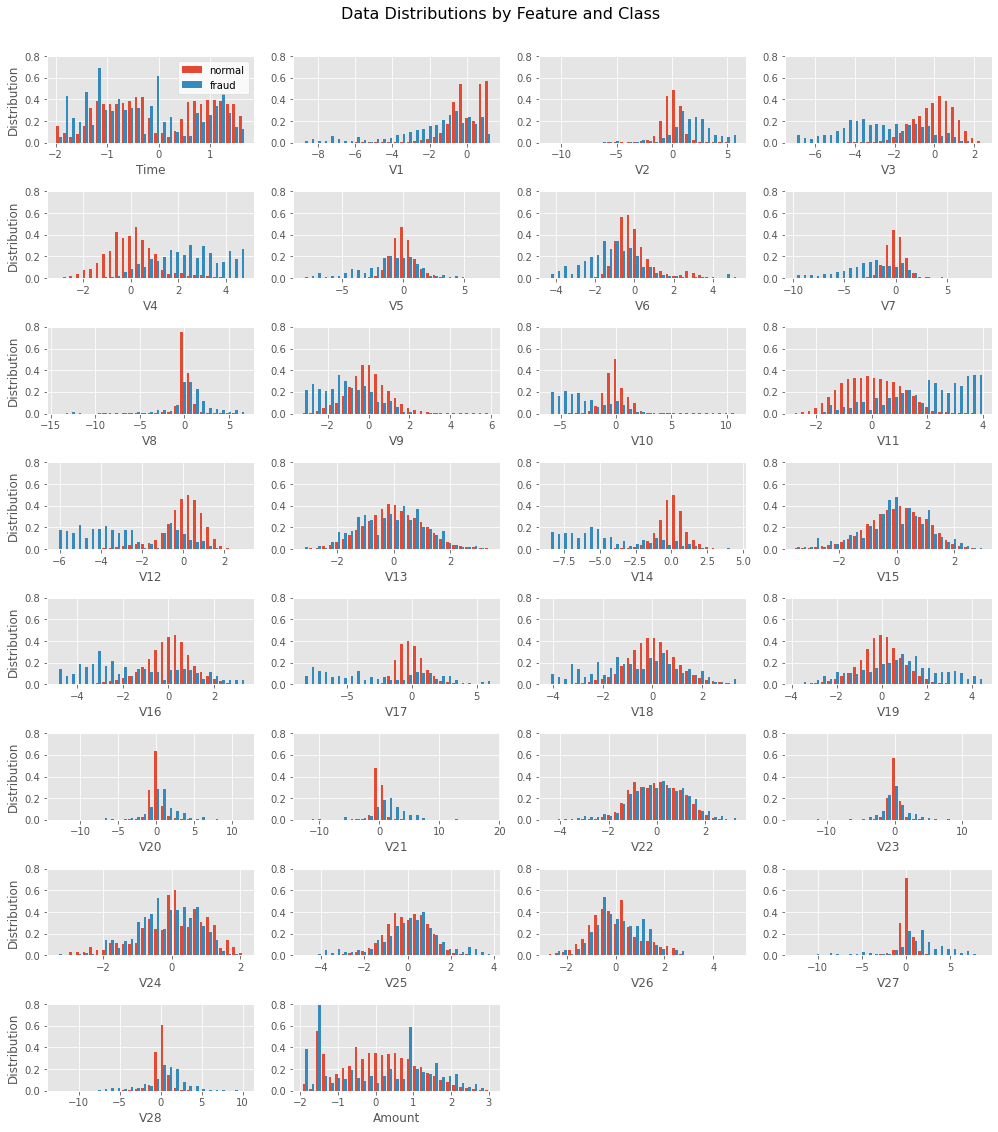

In [43]:
axarr = [[]]*len(data_cols)
columns = 4
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ data.loc[ data.Class == 0, col ], data.loc[ data.Class == 1, col ] ], label=['normal','fraud'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.9), 30 ),density= True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Distribution',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/Engineered_Data_Distributions.png')
plt.show()

In [44]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

In [45]:
train = data.loc[ data['Class']==1 ].copy()

#print( pd.DataFrame( [ [np.sum(train['Class']==i)] for i in np.unique(train['Class']) ], columns=['count'], index=np.unique(train['Class']) ) )

# train = pd.get_dummies(train, columns=['Class'], prefix='Class')
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]

In [46]:
# reloading the libraries and setting the parameters

rand_dim = 32 # 32 # needs to be ~data_dim
base_n_count = 128 # 128

nb_steps = 5000 + 1 # 50000 # Add one for logging of the last interval
batch_size = 128 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 500 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4 # 5e-5
data_dir = '/content/sample_data/cache-new/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

train = train.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim:  30
data_cols:  ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_18 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_19 (Dense)             (None, 30)                15390     
Total params: 184,222
T

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Step: 0 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.6942, 0.7176, 0.7190, 0.9939
D Real - D Gen: 0.0014


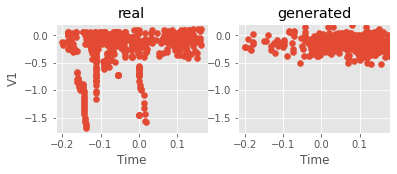

Step: 500 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.2871, 0.5606, 0.6518, 0.9695
D Real - D Gen: 0.0912


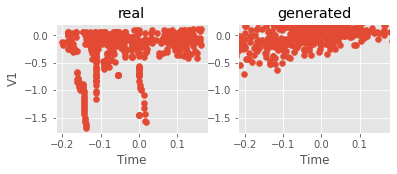

Step: 1000 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.3596, 0.4795, 0.5174, 0.9370
D Real - D Gen: 0.0380


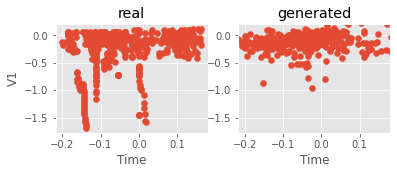

Step: 1500 of 5001.
Losses: G, D Gen, D Real, Xgb: 1.5474, 0.3804, 0.4694, 0.8699
D Real - D Gen: 0.0890


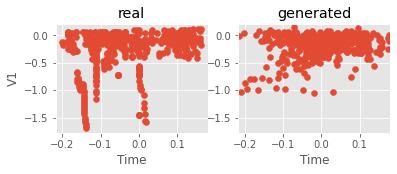

Step: 2000 of 5001.
Losses: G, D Gen, D Real, Xgb: 2.4534, 0.3287, 0.3265, 0.8130
D Real - D Gen: -0.0022


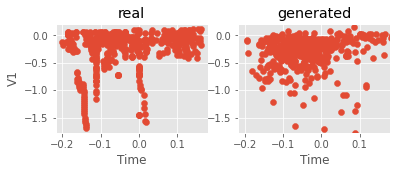

Step: 2500 of 5001.
Losses: G, D Gen, D Real, Xgb: 3.4307, 0.1437, 0.2216, 0.8638
D Real - D Gen: 0.0779


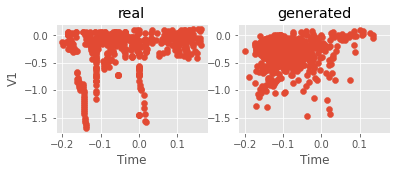

Step: 3000 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.5115, 0.1306, 0.2079, 0.9248
D Real - D Gen: 0.0773


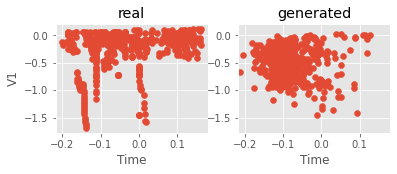

Step: 3500 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.8380, 0.1664, 0.1955, 0.9431
D Real - D Gen: 0.0292


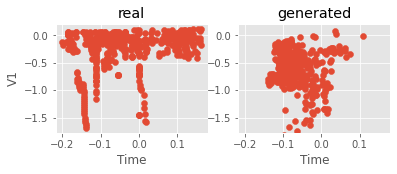

Step: 4000 of 5001.
Losses: G, D Gen, D Real, Xgb: 5.1979, 0.0490, 0.0837, 0.9614
D Real - D Gen: 0.0347


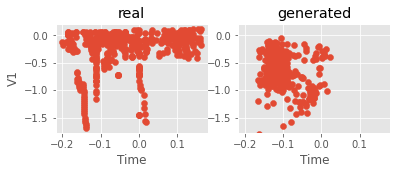

Step: 4500 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.5495, 0.0593, 0.1987, 0.9268
D Real - D Gen: 0.1394


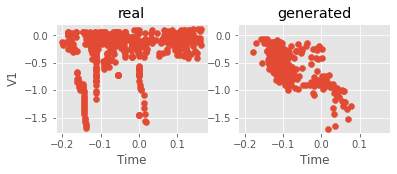

Step: 5000 of 5001.
Losses: G, D Gen, D Real, Xgb: 4.6139, 0.0873, 0.1615, 0.9533
D Real - D Gen: 0.0742


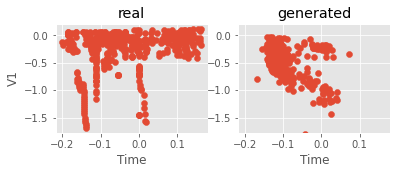

CPU times: user 4min 41s, sys: 12.2 s, total: 4min 53s
Wall time: 4min 22s


In [47]:
%%time

# Training the vanilla GAN and wGAN architectures

k_d = 1  # number of critic network updates per adversarial training step
learning_rate = 5e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_GAN(arguments, train_no_label, data_cols ) # GAN

Instructions for updating:
non-resource variables are not supported in the long term
data_dim:  30
data_cols:  ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '



Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_25 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_26 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_27 (Dense)             (None, 30)                15390     
Total params: 184,222
Trainable params: 184,222
Non-trainable params: 0
_________________________________________________________________
None
Model: "discriminator"
_________________________________________________________________
Layer (type)          

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Step: 0 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0315, -0.0307, 0.0142, 0.9837
D Real - D Gen: 0.0449


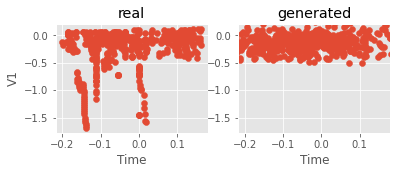

Step: 500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0199, -0.0222, 0.0721, 0.7561
D Real - D Gen: 0.0943


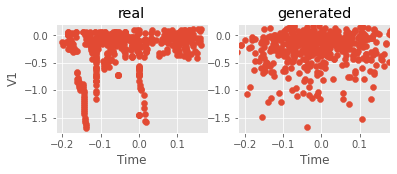

Step: 1000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0261, -0.0383, 0.0726, 0.7358
D Real - D Gen: 0.1109


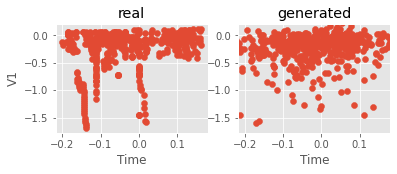

Step: 1500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0444, -0.0424, 0.0274, 0.7703
D Real - D Gen: 0.0698


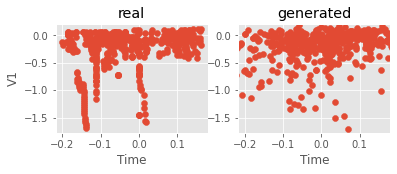

Step: 2000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0347, -0.0384, 0.0203, 0.7846
D Real - D Gen: 0.0587


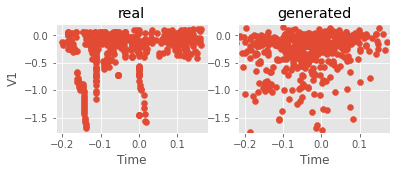

Step: 2500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0402, -0.0404, 0.0133, 0.7663
D Real - D Gen: 0.0537


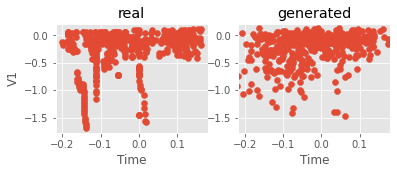

Step: 3000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0407, -0.0334, 0.0291, 0.7907
D Real - D Gen: 0.0625


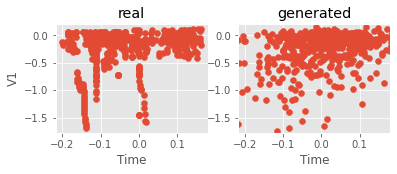

Step: 3500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0203, -0.0320, 0.0293, 0.7480
D Real - D Gen: 0.0613


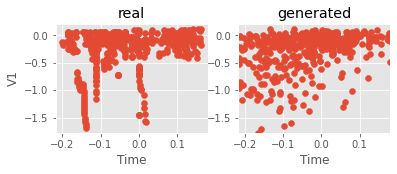

Step: 4000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0210, -0.0294, 0.0216, 0.7561
D Real - D Gen: 0.0510


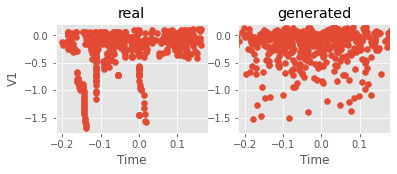

Step: 4500 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0194, -0.0200, 0.0297, 0.7541
D Real - D Gen: 0.0496


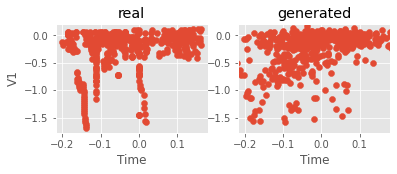

Step: 5000 of 5001.
Losses: G, D Gen, D Real, Xgb: 0.0068, -0.0111, 0.0443, 0.7459
D Real - D Gen: 0.0554


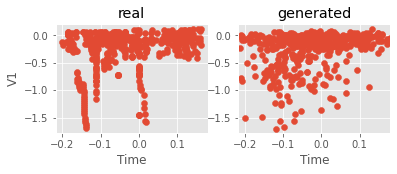

CPU times: user 2min 6s, sys: 9.29 s, total: 2min 15s
Wall time: 1min 42s


In [48]:
%%time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
# Training the WGAN 

k_d = 5 # train critic to optimal state each time
learning_rate = 1e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols )

In [49]:
# For reloading loss data from pickles

prefix = 'GAN'
step = 5000

[combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(
    open(data_dir+prefix+'_losses_step_'+str(step)+'.pkl','rb'))

prefix = 'WGAN'
step = 5000

[wg_combined_loss, wg_disc_loss_generated, wg_disc_loss_real, wg_xgb_losses] = pickle.load(
    open(data_dir+prefix+'_losses_step_'+str(step)+'.pkl','rb'))

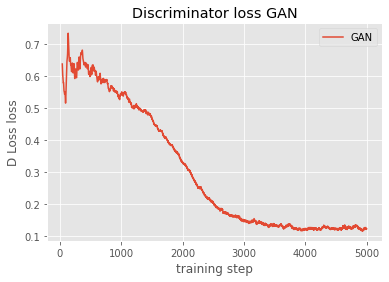

In [50]:
w = 40
plt.title('Discriminator loss GAN')
# plt.plot( list(range(0,5001,1)), pd.rolling_mean((np.array(disc_loss_real) - np.array(disc_loss_generated)),w) )
plt.plot(pd.DataFrame(np.add(disc_loss_generated[:],disc_loss_real[:]) *0.5).rolling(w).mean()  ,label='GAN') ;

plt.ylabel("D Loss loss")
plt.xlabel('training step')
plt.legend()
plt.show()

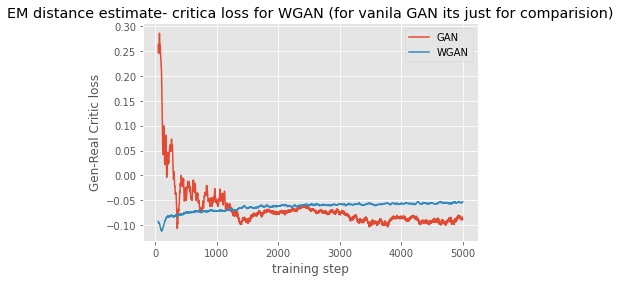

In [51]:

w = 50
plt.title('EM distance estimate- critica loss for WGAN (for vanila GAN its just for comparision)')
# plt.plot( list(range(0,5001,1)), pd.rolling_mean((np.array(disc_loss_real) - np.array(disc_loss_generated)),w) )
plt.plot(pd.DataFrame(disc_loss_generated[:]).rolling(w).mean() - pd.DataFrame(disc_loss_real[:]).rolling(w).mean() ,label='GAN') ;
plt.plot( pd.DataFrame(wg_disc_loss_generated[:]).rolling(w).mean() - pd.DataFrame(wg_disc_loss_real[:]).rolling(w).mean(),label='WGAN') ;
plt.ylabel("Gen-Real Critic loss")
plt.xlabel('training step')
plt.legend()
plt.show()
#For vanila GAN we dont optimze based on EM distance though. Below is jys for camparision we plotted.
#Below Graph shows WGAN the EM distance is low right from starting and try to converge very quickly
#WGAN we should try max(real-Gen loss) but instead we look for min (Gen-real loss)

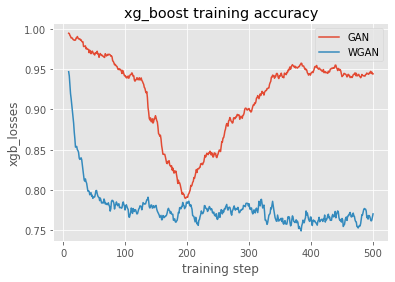

In [52]:
w=10
plt.title('xg_boost training accuracy')
plt.ylabel("xgb_losses")
plt.xlabel('training step')
#print(pd.DataFrame(xgb_losses[:]))
#np.array(range(0,len(xgb_losses)))*10,
plt.plot( pd.DataFrame(xgb_losses[:]).rolling(w).mean(),label='GAN' ) 

plt.plot( pd.DataFrame(wg_xgb_losses[:]).rolling(w).mean() , label='WGAN')
plt.legend()
plt.show()
#XG_boot is done on batches for certain number for epoch interval 5000. 
#When Real = Gen data then XGBoost should be random and 
# have 50% probability. As seen below WGAN is converging fastly 0.5 than vanila GAN after 5000 iterations
# We take 2000 step of GAN of generator model for generating data
# We take 5000step of WGAN of generator model for generating data

In [54]:
#label_cols
#data_cols
x = get_data_batch(train_no_label, test_size, seed=i+1)
#print( CheckAccuracy( x, g_z, data_cols, seed=0, with_class=False, data_dim=data_dim ) )

#gen_samples = pd.DataFrame(g_z, columns=data_cols)
real_samples = pd.DataFrame(x, columns=data_cols)    
#f, axarr = plt.subplots(1, 2, figsize=(6,2) )
#axarr[0].scatter( real_samples[data_cols[0]], real_samples[data_cols[1]])
#axarr[1].scatter( gen_samples[data_cols[0]], gen_samples[data_cols[1]]) #, cmap='plasma'  )
#axarr[0].set_title('real')
#axarr[1].set_title('generated')   
#axarr[0].set_ylabel(data_cols[1])
#for a in axarr: a.set_xlabel(data_cols[0]) # Add x label to both plots
#axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())
#plt.show()

In [55]:
rand_dim = 32
base_n_count = 128
model_names = ['GAN','WGAN']
with_classes = [False, False]

models = {}

for model_name, with_class in zip(model_names, with_classes ):
    generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)   
    
    models[model_name] = [ model_name, with_class, generator_model ]

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000


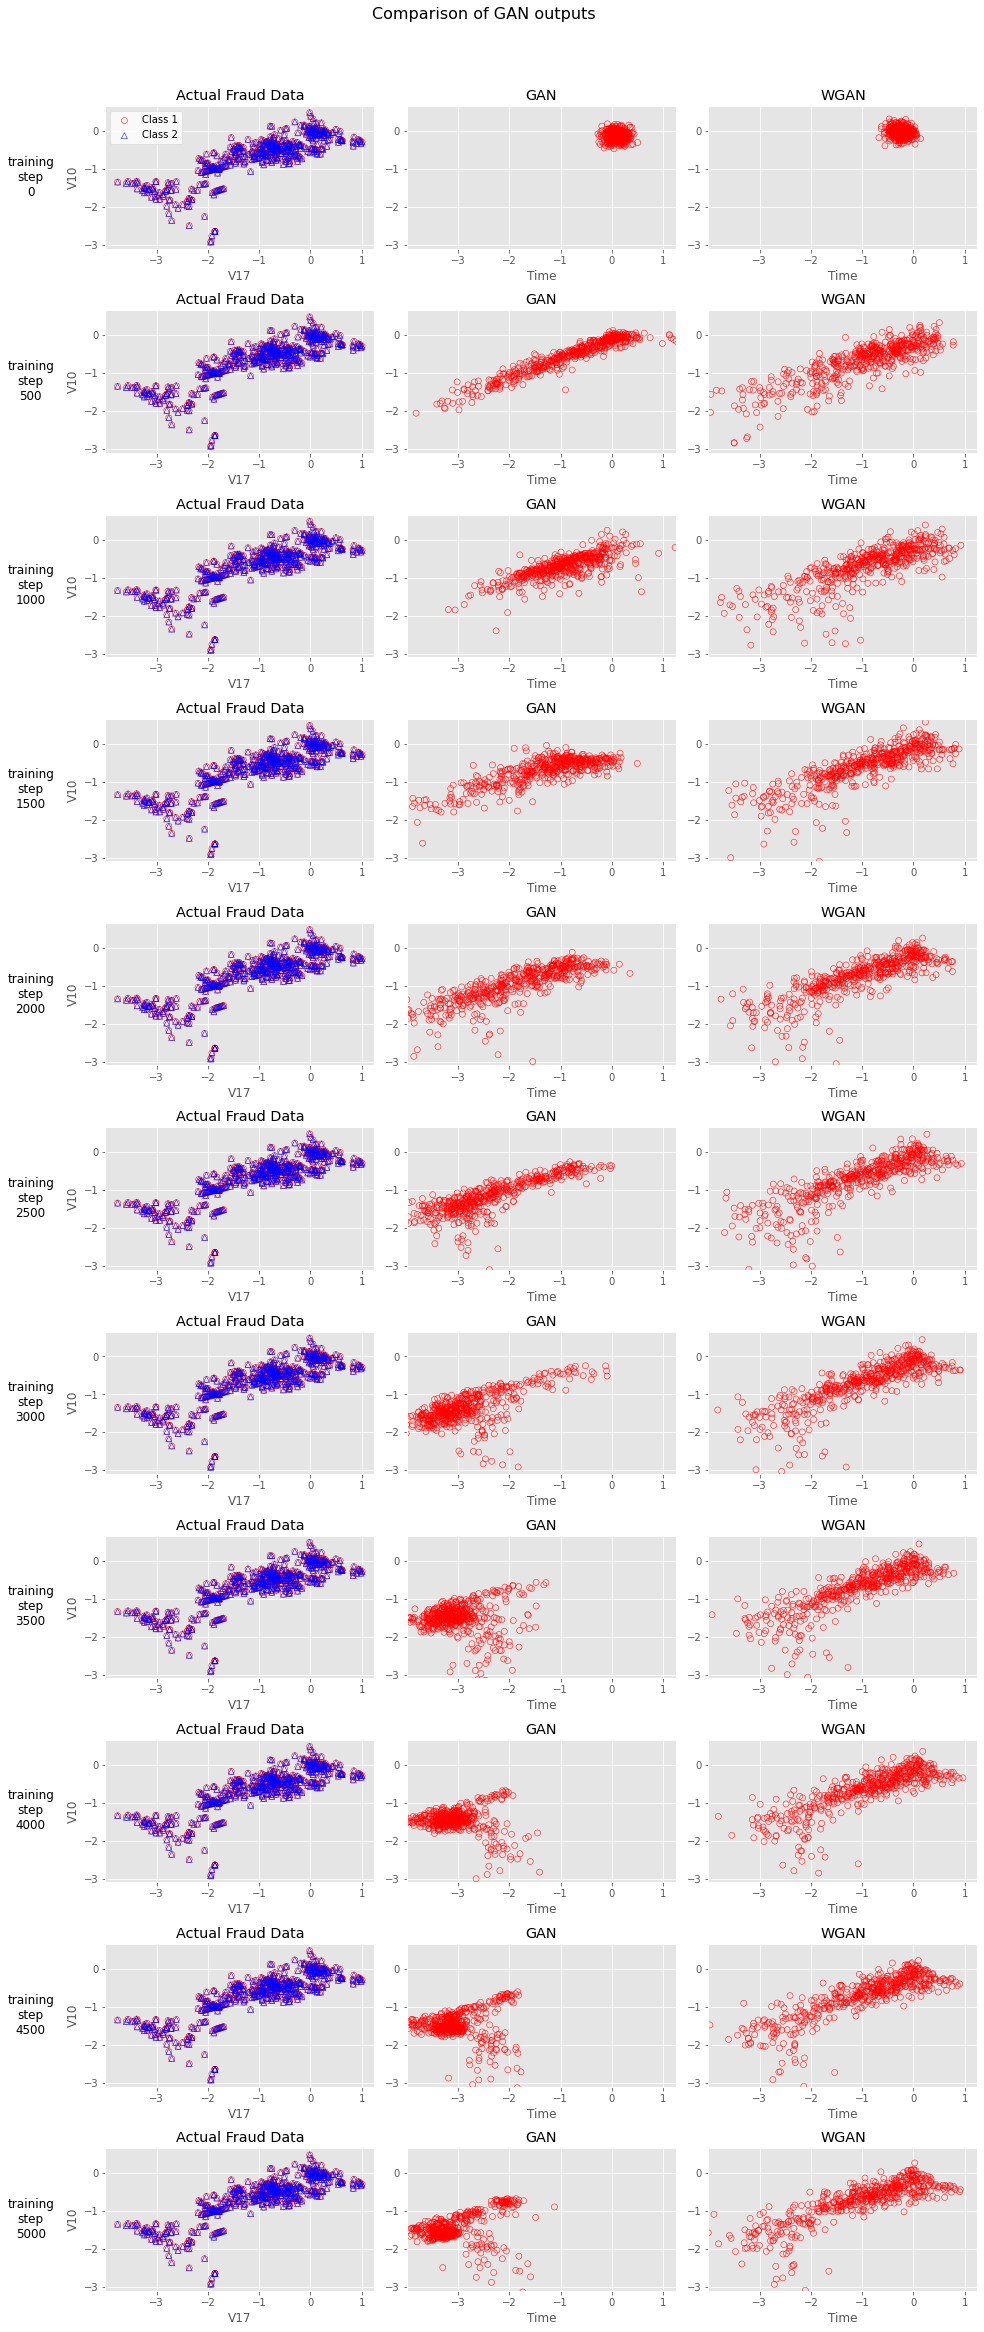

In [57]:
model_steps = [ 0, 500,  1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
rows = len(model_steps)
columns = 3
col1, col2 = 'V17', 'V10'
class_labels = ['Class 1','Class 2']
colors = ['red','blue']
markers = ['o','^']
axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate( model_steps ):
    print(model_step)
        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for  color, marker, label in zip( colors, markers, class_labels ):
        plt.scatter( real_samples[[col1]], real_samples[[col2]], 
                        label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
        
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):
        
        [ model_name, with_class, generator_model ] = models[model_name]
        
        generator_model.load_weights( data_dir + model_name + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )
        
    
        g_z = generator_model.predict(z)
        gen_samples = pd.DataFrame(g_z, columns=data_cols)
        plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
          label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)


plt.suptitle('Comparison of GAN outputs', size=16)
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

#As seen below we dont see mode collapse in WGAN after 5000 steps

In [65]:
#Generating data from GAN generator model with loading weights from step 2000 which has least discriminator loss

seed = 17
data_dim = len(data_cols)

with_class = False
np.random.seed(seed)
generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)
generator_model.load_weights('/content/sample_data/cache-new/GAN_generator_model_weights_step_2000.h5')

test_size = 50000 # Equal to all of the fraud cases

z = np.random.normal(size=(test_size, rand_dim))
g_z = generator_model.predict(z)
pd.DataFrame(g_z).to_csv("/content/sample_data/cache-new/GAN_generated_data.csv")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [66]:
#Generating data from GAN generator model with loading weights from step 2000 which has least discriminator loss

wgan_generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)
wgan_generator_model.load_weights('/content/sample_data/cache-new/WGAN_generator_model_weights_step_5000.h5')

test_size = 50000 # Equal to all of the fraud cases

z = np.random.normal(size=(test_size, rand_dim))
g_z = wgan_generator_model.predict(z)
pd.DataFrame(g_z).to_csv("/content/sample_data/cache-new/WGAN_generated_data.csv")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
